# Interacting with MaskCLIP

This is a self-contained notebook that shows how to download and run MaskCLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `maskclip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/lucasb-eyer/pydensecrf.git
! pip install git+https://github.com/akanametov/MaskCLIP.git

  Cloning https://github.com/akanametov/MaskCLIP.git to /tmp/pip-req-build-jb9t39nz
  Running command git clone -q https://github.com/akanametov/MaskCLIP.git /tmp/pip-req-build-jb9t39nz
  Resolved https://github.com/akanametov/MaskCLIP.git to commit 47dc14d8ef058a88911a9d69f438a26728ade027


In [1]:
from PIL import Image
import numpy as np
import requests
import torch
from torch.nn import functional as F
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.10.0


# Loading the model

`maskclip.available_models()` will list the names of available MaskCLIP models.

In [2]:
import maskclip

maskclip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

`maskclip.available_datasets()` will list the names of available datasets.

In [3]:
maskclip.available_datasets()

['voc', 'context', 'stuff']

In [4]:
device = "cuda"

model, preprocess = maskclip.load("ViT-L/14", input_resolution=512, device=device)
model = model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{sum([p.numel() for p in model.parameters()]):,}")
print("Input resolution of CLIP model:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 428,681,473
Input resolution of CLIP model: 512
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `maskclip.load()` contains a torchvision `Transform` that performs this preprocessing. An image input resolution can be different `maskclip.load(..., input_resolution=...)` from that expected by model (`224`). As default `input_resolution=512`.

In [5]:
preprocess

Compose(
    Resize(size=(512, 512), interpolation=bicubic, max_size=None, antialias=None)
    <function _convert_image_to_rgb at 0x7fbe7638a550>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `maskclip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
maskclip.tokenize("dog")

tensor([[49406,  1929, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Zero-Shot Image Segmentation

You can segment images using text embeddings of classes in couple with image.

In [7]:
url = 'http://farm3.staticflickr.com/2660/3861289131_cd9172b027_z.jpg'

img = Image.open(requests.get(url, stream=True).raw)

x = preprocess(img).unsqueeze(0).to(device)
text = maskclip.tokenize(["a photo of grass", "a photo of dog"]).to(device)

In [8]:
with torch.no_grad():
    output = model(x, text)
    output = F.interpolate(output, size=x.shape[-2:], mode="bilinear", align_corners=False)

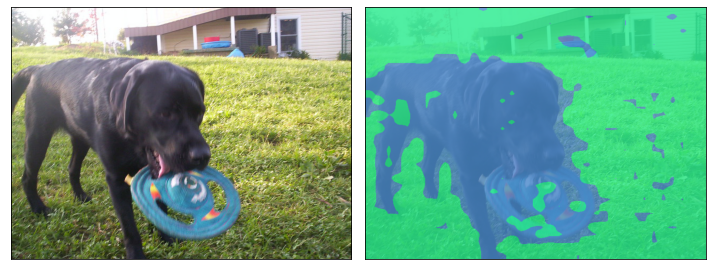

In [9]:
from matplotlib import pyplot as plt

img_grid = maskclip.utils.draw_segmentation(img, output, num_classes=2, random_state=1)

fig, ax = plt.subplots(ncols=len(img_grid), tight_layout=True, figsize=(10, 5))
for i, image in enumerate(img_grid):
    ax[i].imshow(image)
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Predict by initializing `text_embeddings` generated with by 85 prompts.

In [10]:
text_embeddings = maskclip.generate_text_embeddings(model, classnames=["grass", "dog"], feature_layer=-2)
model.initialize_text_embeddings(text_embeddings.half())

In [11]:
with torch.no_grad():
    output = model(x)
    output = F.interpolate(output, size=x.shape[-2:], mode="bilinear", align_corners=False)

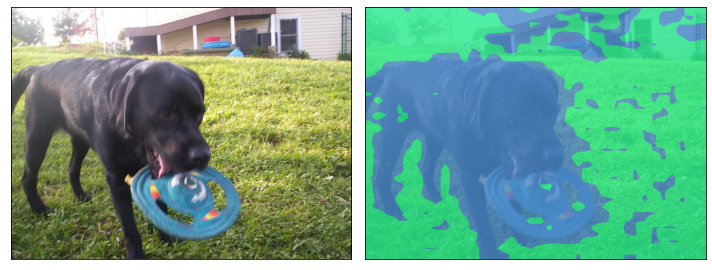

In [12]:
from matplotlib import pyplot as plt

img_grid = maskclip.utils.draw_segmentation(img, output, num_classes=2, random_state=1)

fig, ax = plt.subplots(ncols=len(img_grid), tight_layout=True, figsize=(10, 5))
for i, image in enumerate(img_grid):
    ax[i].imshow(image)
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])